Inspect integrator output values, grouping by different equivalence classings on the dataset.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
from collections import Counter
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.datasets.speech_equivalence import SpeechEquivalenceDataset, SpeechHiddenStateDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, iter_dataset

In [55]:
model_name = "syllable"
model_dir = f"outputs/models/timit/w2v2_8/rnn_8-weightdecay0.01/{model_name}_10frames"
output_dir = f"outputs/notebooks/timit/w2v2_8/rnn_8-weightdecay0.01/{model_name}_10frames/state_space"
dataset_path = "outputs/preprocessed_data/timit"
equivalence_path = f"outputs/equivalence_datasets/timit/w2v2_8/{model_name}_10frames/equivalence.pkl"
hidden_states_path = "outputs/hidden_states/timit/w2v2_8/hidden_states.pkl"
state_space_specs_path = "outputs/state_space_specs/timit/w2v2_8/state_space_specs.pkl"
embeddings_path = f"outputs/model_embeddings/timit/w2v2_8/rnn_8-weightdecay0.01/{model_name}_10frames/embeddings.npy"
word_equivalence_path = f"outputs/equivalence_datasets/timit/w2v2_8/word_broad_10frames/equivalence.pkl"

metric = "cosine"

In [56]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [57]:
with open(word_equivalence_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = torch.load(f)
with open(hidden_states_path, "rb") as f:
    hidden_state_dataset: SpeechHiddenStateDataset = torch.load(f)

In [58]:
ds = datasets.Dataset.from_generator(
    iter_dataset, gen_kwargs=dict(equiv_dataset=equiv_dataset,
                                    hidden_state_dataset=hidden_state_dataset,
                                    max_length=model.config.max_length,
                                    num_examples=min(10000, equiv_dataset.num_instances),
                                    infinite=False)) \
    .with_format("torch")

In [59]:
Counter(["".join(equiv_dataset.class_labels[label_idx]) for label_idx in ds["example_class"].numpy()]).most_common(10)

[('greasy', 155),
 ('that', 150),
 ('carry', 144),
 ('water', 140),
 ('rag', 135),
 ('wash', 135),
 ('suit', 135),
 ('year', 125),
 ('dark', 119),
 ('ask', 117)]

In [60]:
losses, idxs = [], []

def compute_loss_batch(batch, batch_idxs):
    with torch.no_grad():
        model_output = model(batch["example"], batch["example_length"],
                             batch["pos"], batch["pos_length"],
                             batch["neg"], batch["neg_length"],
                             in_batch_soft_negatives=False,
                             loss_reduction=None)
    losses.append(model_output.loss.numpy())
    idxs.append(batch["example_idx"].numpy())
ds.map(compute_loss_batch, batched=True, with_indices=True, batch_size=32)

losses = np.concatenate(losses)
idxs = np.concatenate(idxs)

loss_df = pd.DataFrame({"loss": losses, "idx": idxs,
                        "class": equiv_dataset.Q[idxs].numpy(),
                        "position": idxs - equiv_dataset.S[idxs].numpy()})
loss_df["class_label"] = loss_df["class"].map(lambda idx: " ".join(equiv_dataset.class_labels[idx]))
loss_df["word_length"] = loss_df.class_label.str.count(" ") + 1

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [61]:
loss_df

,loss,idx,class,position,class_label,word_length
0,-19.970589,408105,808,12,p r o j e c t,7
1,-19.952597,329962,380,11,a p p o i n t m e n t,11
2,-1.369774,45810,1024,21,d e t a i l,6
3,-19.702168,69645,6,9,g r e a s y,6
4,0.011488,417149,10,13,y e a r,4
...,...,...,...,...,...,...
9995,4.203853,77744,1491,0,s u m m e r t i m e,10
9996,15.878824,828487,15,11,c a r r y,5
9997,-19.807579,840257,34,7,s o m e,4
9998,-0.031190,855639,209,13,h i m,3


<Axes: xlabel='loss'>

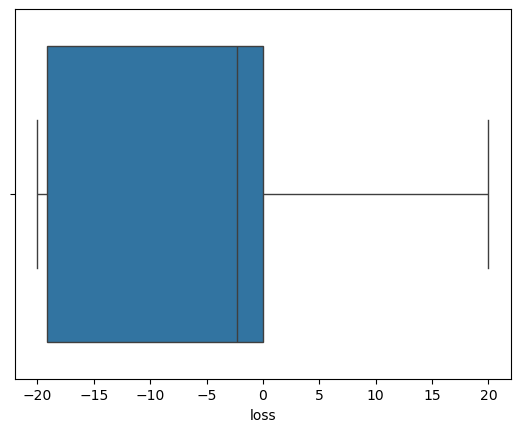

In [62]:
sns.boxplot(data=loss_df, x="loss")

In [63]:
loss_df.to_csv(Path(output_dir) / "loss.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'outputs/notebooks/timit/w2v2_8/rnn_8-weightdecay0.01/syllable_10frames/state_space'

<Axes: xlabel='word_length', ylabel='loss'>

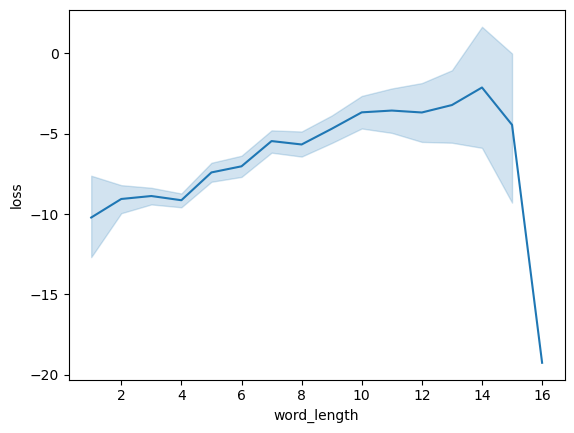

In [64]:
sns.lineplot(data=loss_df, x="word_length", y="loss")

<Axes: xlabel='position', ylabel='loss'>

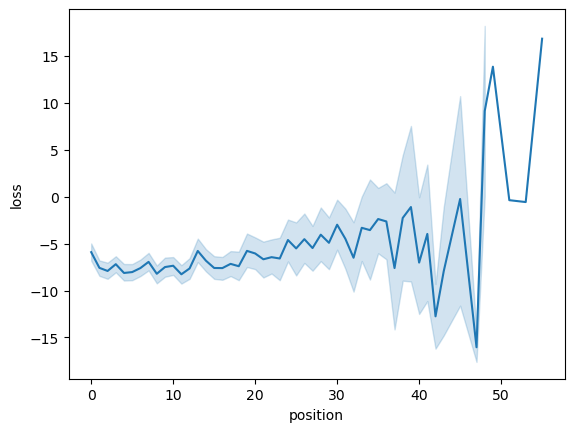

In [65]:
sns.lineplot(data=loss_df, x="position", y="loss")